[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1y7lGPSAkp9kooSlaKyFgzBllXhRmnReC?usp=sharing)

# Transfer learning

With transfer learning, you benefit from both advanced convolutional neural network architectures developed by top researchers and from pre-training on a huge dataset of images. In our case we will be transfer learning from a network trained on ImageNet, a database of images containing many plants and outdoors scenes, which is close enough to flowers.

<img src="https://i.ibb.co/KsLSGyt/transfer-learning.png" alt="transfer-learning" border="0">

[MobileNetV2](https://arxiv.org/abs/1801.04381) is a significant improvement over MobileNetV1 and pushes the state of the art for mobile visual recognition including classification, object detection and semantic segmentation.

In [`tf.keras.applications`](https://www.tensorflow.org/api_docs/python/tf/keras/applications) you have many pre-trained models. You can compare them [here](https://keras.io/api/applications/#available-models).

With the parameter `include_top=False`, you can delete the last `softmax` layer.

With `pretrained_model.trainable = False`, you freeze the pre-trained model weights.

In [ ]:
%matplotlib inline

import pathlib
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

tf.keras.utils.set_random_seed(0)

In [ ]:
def show_loss_accuracy_evolution(history):

    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Sparse Categorical Crossentropy')
    ax1.plot(hist['epoch'], hist['loss'], label='Train Error')
    ax1.plot(hist['epoch'], hist['val_loss'], label = 'Val Error')
    ax1.grid()
    ax1.legend()

    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.plot(hist['epoch'], hist['accuracy'], label='Train Accuracy')
    ax2.plot(hist['epoch'], hist['val_accuracy'], label = 'Val Accuracy')
    ax2.grid()
    ax2.legend()

    plt.show()

def show_errors(val_ds, model, class_names_list, n_images=10):
    n_plots = 0
    for images, labels in val_ds:
        pred_probs = model.predict(images)
        preds = pred_probs.argmax(axis=-1)
        bad_pred_inds = np.where(preds != labels)[0]
        for ind in list(bad_pred_inds):
            n_plots += 1
            real_class = class_names_list[labels[ind].numpy()]
            pred_class = class_names_list[preds[ind]]
            prob = pred_probs[ind].max()
            prob_real = pred_probs[ind][[
                i for i, c in enumerate(class_names_list) if c == real_class
            ][0]]
            plt.imshow(images[ind].numpy().astype("uint8"))
            plt.title(
                'Predicted: {0}, prob: {1:.2f} \n real: {2}, prob: {3:.2f}'
                .format(pred_class, prob, real_class, prob_real))
            plt.show()

            if n_plots == n_images:
                return
    return

In [ ]:
image_size = (96,96)
dataset_url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,  # 80%  train, 20% validation
  subset='training',  # 'training' o 'validation', only  with 'validation_split'
  seed=1,
  image_size=image_size,  # Dimension (img_height, img_width) for rescaling
  batch_size=64
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset='validation',
  seed=1,
  image_size=image_size,
  batch_size=64)

class_names_list = train_ds.class_names

228813984/228813984 [==============================] - 1s 0us/step
Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
image_size = (96,96)

pretrained_model = tf.keras.applications.MobileNetV2(input_shape=image_size+(3,), include_top=False)
pretrained_model.trainable = False
pretrained_model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 48, 48, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 48, 48, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU

We need to use the same **preprocessing** as in the model

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

You define your new model adding more layers

In [ ]:
inputs = tf.keras.Input(shape=image_size + (3, ), name='input')

# pre-trained model
x = preprocess_input(inputs)
x = pretrained_model(x)

# classifier
flat = tf.keras.layers.Flatten()(x)
flat = tf.keras.layers.Dropout(0.5)(flat)
outputs = tf.keras.layers.Dense(5, activation='softmax')(flat)

model_tl = tf.keras.Model(inputs, outputs)
model_tl.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 96, 96, 3)         0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 96, 96, 3)         0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 3, 3, 1280)        2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 11520)             0         
                                                             

In [ ]:
model_tl.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
epochs = 5
history = model_tl.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
46/46 [==============================] - 13s 128ms/step - loss: 1.0735 - accuracy: 0.7170 - val_loss: 0.6172 - val_accuracy: 0.8474
Epoch 2/5
46/46 [==============================] - 5s 88ms/step - loss: 0.3350 - accuracy: 0.8968 - val_loss: 0.5581 - val_accuracy: 0.8624
Epoch 3/5
46/46 [==============================] - 4s 83ms/step - loss: 0.2208 - accuracy: 0.9264 - val_loss: 0.6062 - val_accuracy: 0.8665
Epoch 4/5
46/46 [==============================] - 5s 102ms/step - loss: 0.1281 - accuracy: 0.9510 - val_loss: 0.6210 - val_accuracy: 0.8610
Epoch 5/5
46/46 [==============================] - 4s 81ms/step - loss: 0.1070 - accuracy: 0.9636 - val_loss: 0.6590 - val_accuracy: 0.8569


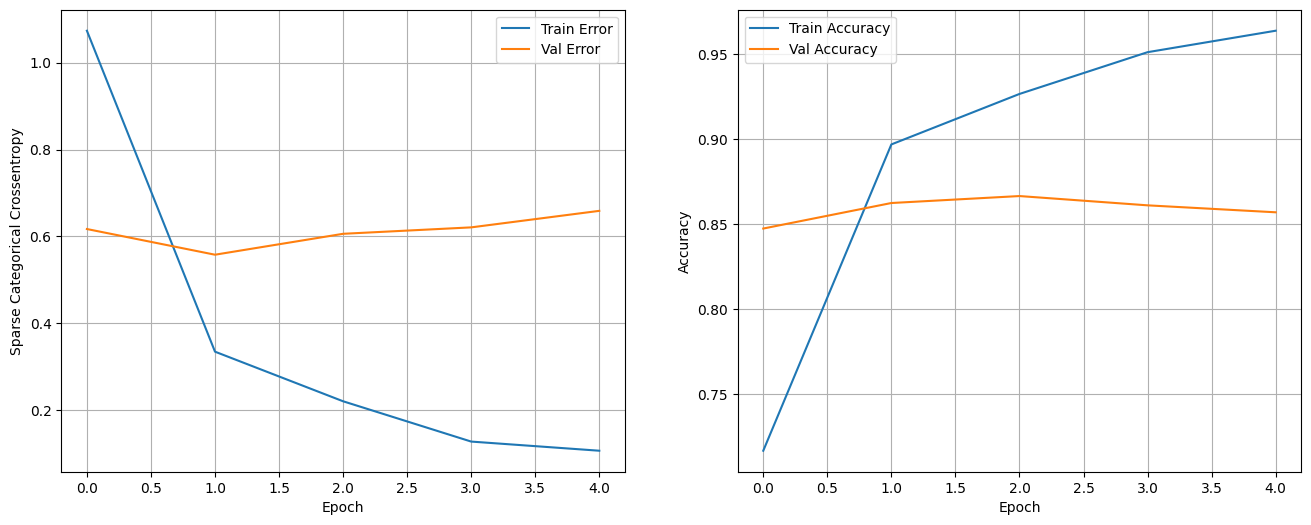

In [ ]:
show_loss_accuracy_evolution(history)

2/2 [==============================] - 1s 11ms/step


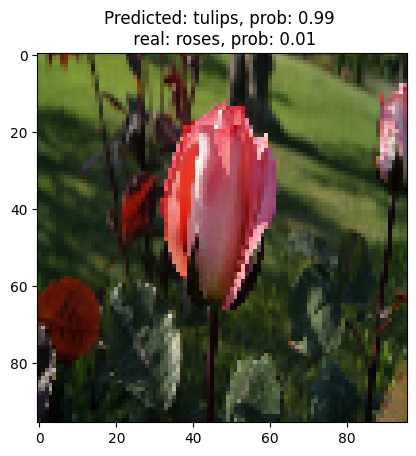

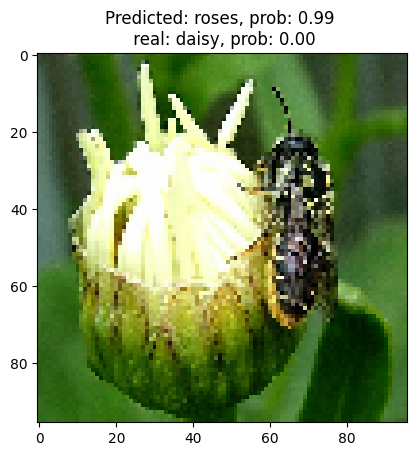

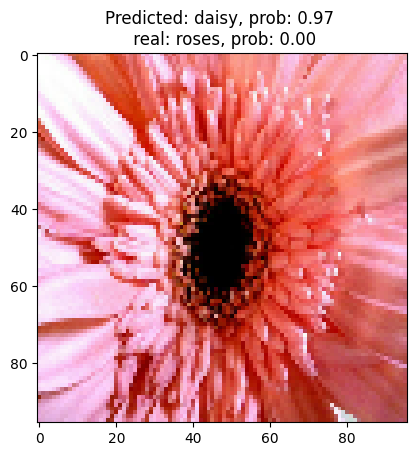

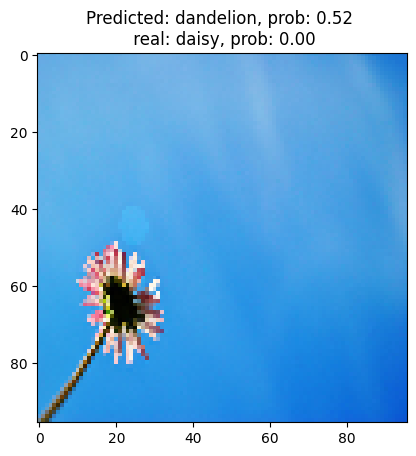

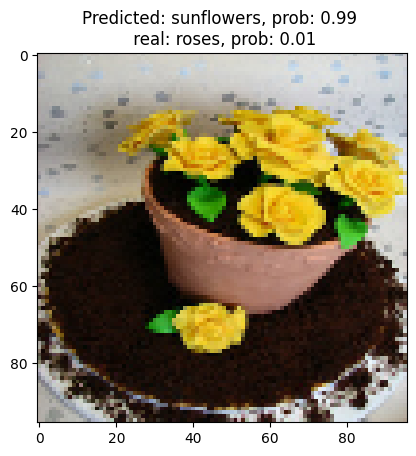

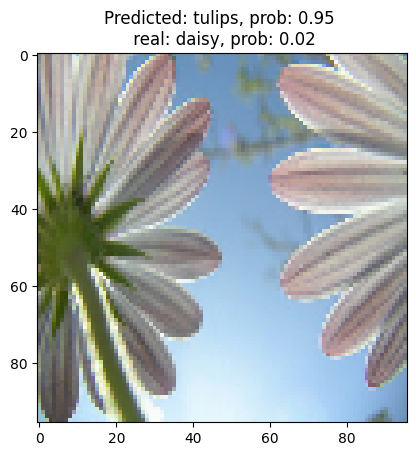

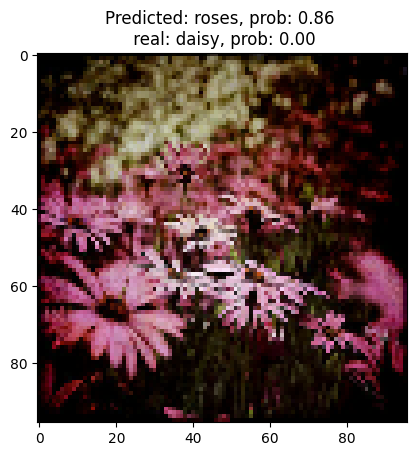

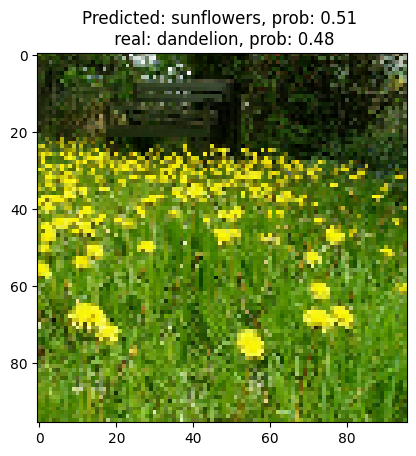

2/2 [==============================] - 0s 39ms/step


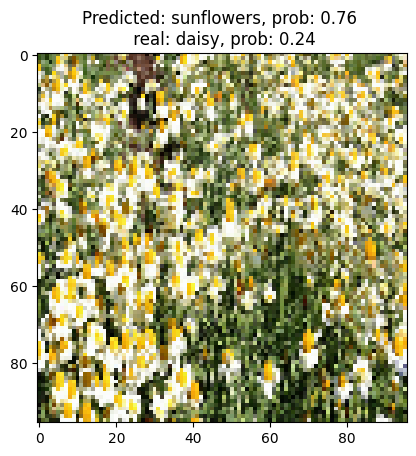

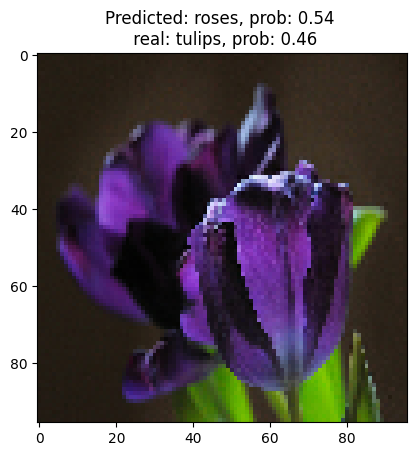

In [ ]:
show_errors(val_ds, model_tl, class_names_list, n_images=10)

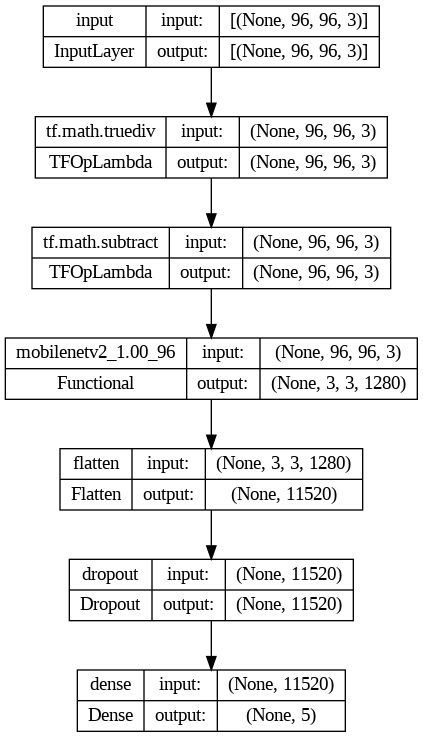

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_tl, show_shapes=True)

In [ ]:
inputs = tf.keras.Input(shape=image_size+(3, ), name='input')

#data_aug = data_augmentation(inputs)
reescaling = preprocess_input(inputs)

# Conv Layer 1
conv_1 = layers.Conv2D(16, 3, padding='valid',
                       activation='relu', name='conv_1')(reescaling)
pool_1 = layers.MaxPooling2D(pool_size=(
    2, 2),  name='pool_1')(conv_1)
pool_1 = layers.Dropout(0.4)(pool_1)

# Conv Layer 2
conv_2 = layers.Conv2D(16, 3, padding='valid',
                       activation='relu', name='conv_2')(pool_1)
pool_2 = layers.MaxPooling2D(name='pool_2')(conv_2)
pool_2 = layers.Dropout(0.4)(pool_2)

# Conv Layer 3
conv_3 = layers.Conv2D(16, 3, padding='valid',
                       activation='relu', name='conv_3')(pool_2)
pool_3 = layers.MaxPooling2D(name='pool_3')(conv_3)
pool_3 = layers.Dropout(0.4)(pool_3)

# Fully-connected
x1 = layers.Flatten(name='flatten')(pool_3)

x2 = pretrained_model(reescaling, training=False)
x2 = tf.keras.layers.Flatten()(x2)

x = tf.keras.layers.Concatenate()([x1, x2])
x = layers.Dropout(0.4)(x)
x = layers.Dense(64, activation='relu', name='dense')(x)
# A Dense classifier with a single unit (binary classification
outputs = tf.keras.layers.Dense(5, activation='softmax')(x)
model_tl = keras.Model(inputs, outputs)

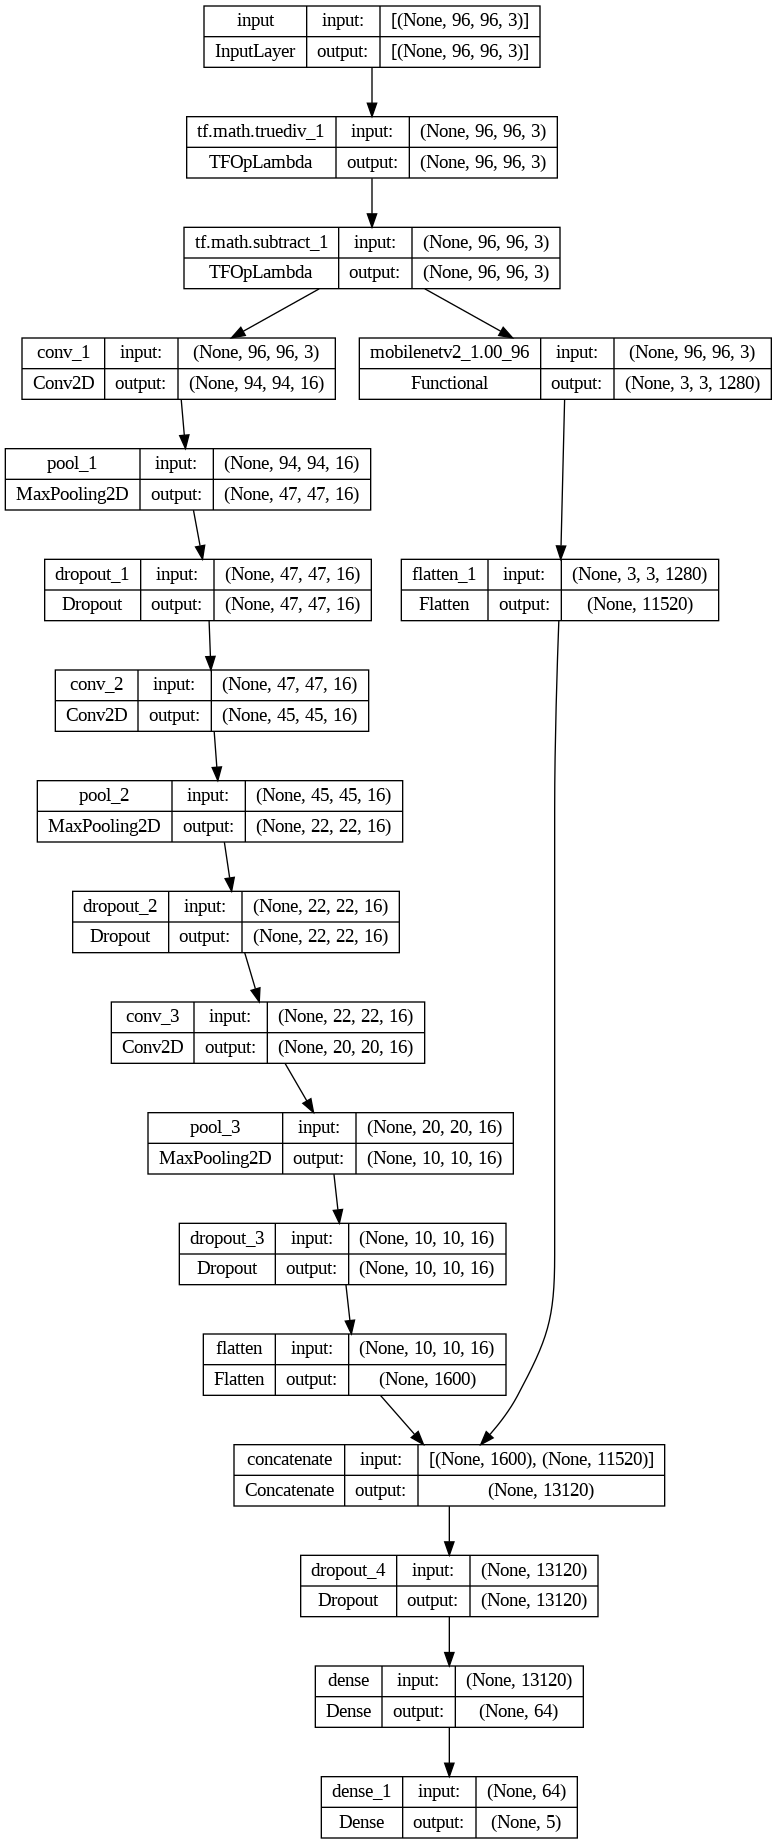

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_tl, show_shapes=True)

In [ ]:
model_tl.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
epochs = 10
history = model_tl.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
46/46 [==============================] - 12s 147ms/step - loss: 0.7506 - accuracy: 0.7585 - val_loss: 0.4517 - val_accuracy: 0.8597
Epoch 2/10
46/46 [==============================] - 4s 85ms/step - loss: 0.2135 - accuracy: 0.9227 - val_loss: 0.4787 - val_accuracy: 0.8529
Epoch 3/10
46/46 [==============================] - 5s 90ms/step - loss: 0.1221 - accuracy: 0.9561 - val_loss: 0.5499 - val_accuracy: 0.8433
Epoch 4/10
46/46 [==============================] - 5s 89ms/step - loss: 0.0692 - accuracy: 0.9779 - val_loss: 0.5250 - val_accuracy: 0.8569
Epoch 5/10
46/46 [==============================] - 4s 84ms/step - loss: 0.0475 - accuracy: 0.9833 - val_loss: 0.5938 - val_accuracy: 0.8624
Epoch 6/10
46/46 [==============================] - 5s 105ms/step - loss: 0.0274 - accuracy: 0.9932 - val_loss: 0.5439 - val_accuracy: 0.8719
Epoch 7/10
46/46 [==============================] - 5s 87ms/step - loss: 0.0185 - accuracy: 0.9966 - val_loss: 0.5823 - val_accuracy: 0.8692
Epoch 8/10

2/2 [==============================] - 1s 19ms/step


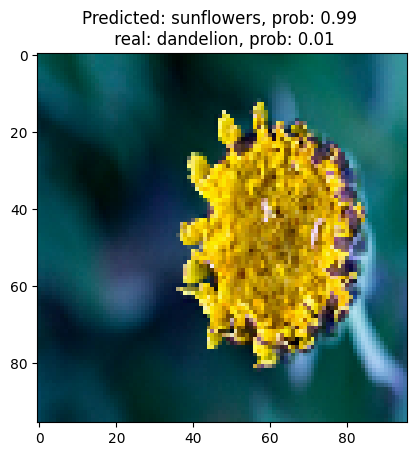

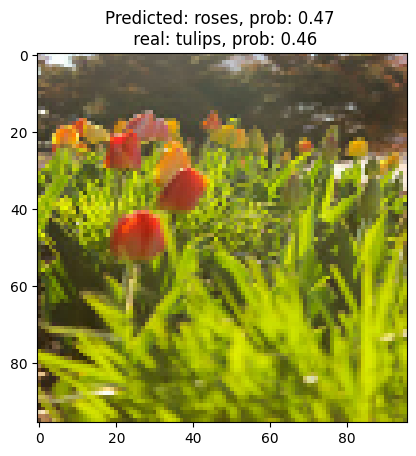

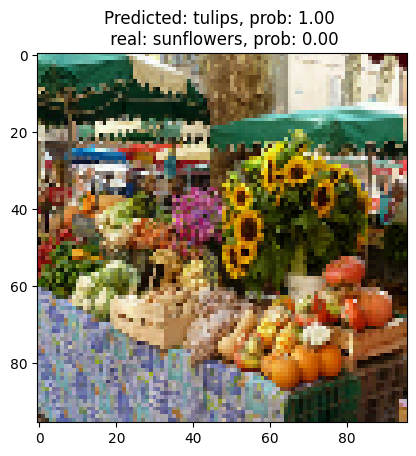

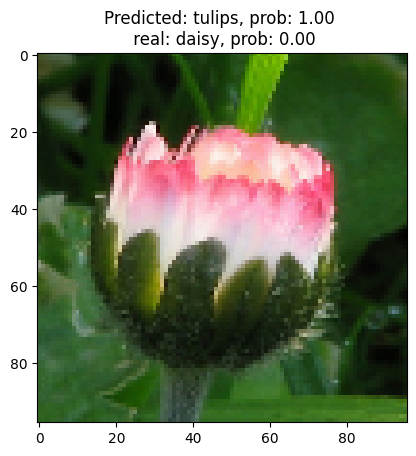

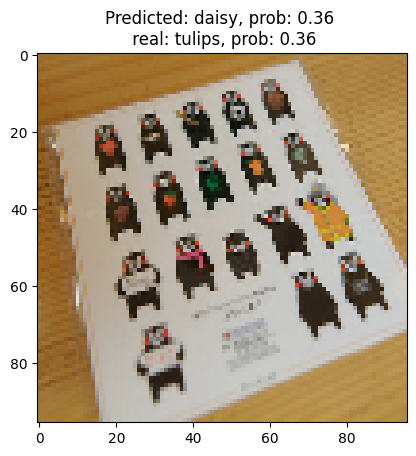

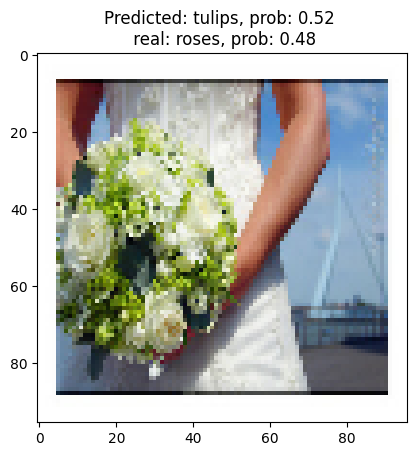

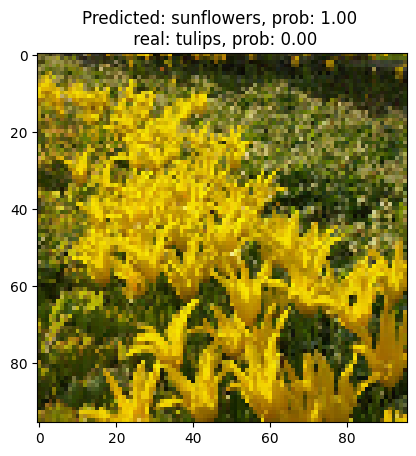

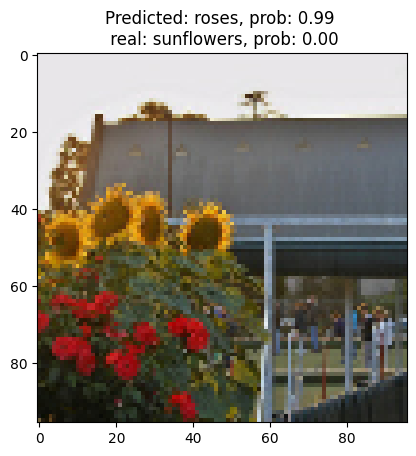

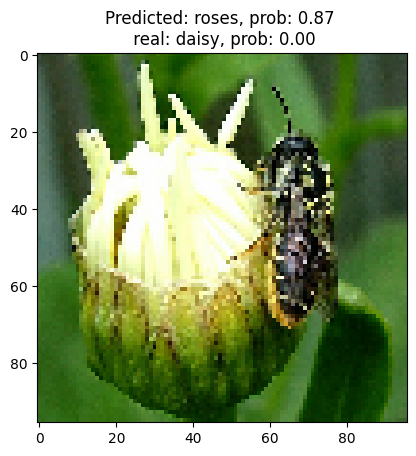

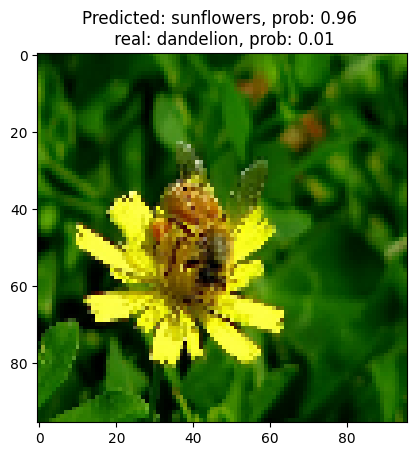

In [ ]:
show_errors(val_ds, model_tl, class_names_list, n_images=10)

### Fine-tuning

In [ ]:
epochs = 20

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.25),
    layers.RandomZoom(0.25),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(factor=0.2)
  ]
)

model_tl = tf.keras.Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    tf.keras.applications.MobileNetV2(input_shape=image_size+(3, ), include_top=False),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')
])
model_tl.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
history = model_tl.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
46/46 [==============================] - 35s 158ms/step - loss: 1.4067 - accuracy: 0.5787 - val_loss: 1.0132 - val_accuracy: 0.7139
Epoch 2/20
46/46 [==============================] - 6s 126ms/step - loss: 0.7561 - accuracy: 0.7575 - val_loss: 1.0003 - val_accuracy: 0.7725
Epoch 3/20
46/46 [==============================] - 5s 105ms/step - loss: 0.6216 - accuracy: 0.8096 - val_loss: 0.9698 - val_accuracy: 0.8052
Epoch 4/20
46/46 [==============================] - 7s 136ms/step - loss: 0.5824 - accuracy: 0.8164 - val_loss: 0.8542 - val_accuracy: 0.8243
Epoch 5/20
46/46 [==============================] - 5s 105ms/step - loss: 0.4941 - accuracy: 0.8382 - val_loss: 0.9461 - val_accuracy: 0.8243
Epoch 6/20
46/46 [==============================] - 6s 126ms/step - loss: 0.4479 - accuracy: 0.8457 - val_loss: 1.1791 - val_accuracy: 0.8147
Epoch 7/20
46/46 [==============================] - 6s 118ms/step - loss: 0.3643 - accuracy: 0.8651 - val_loss: 1.0656 - val_accuracy: 0.8202
Epoch